# First Set of Experiments
+ 6 arms, with mean reward $\{1, 4/5, 3/5, 2/5, 1/5, 0\}$
+ Gaussian Rewand with variance $1/4$
+ $\delta=0.1$, $\epsilon=0.01$

In [1]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

from Source.agent import ActionElimination_agent, UCB_agent, LUCB_agent
from Source.env import Environment_Gaussian

In [2]:
# numeric setting
K = 6
rlist = np.linspace(1.0, 0.0, K)
H1 = np.sum(1 / (rlist[1:] - rlist[0])**2)
print(f"H1 is {H1}")

delta = 0.1
epsilon = 0.01
n_experiment = 5000

T = 70 * int(H1)

H1 is 36.59027777777779


## Figure for Action Elimination

In [3]:
# conduct the experiment
action_history_AE = []
prediction_AE = np.zeros(n_experiment)

for exp_index in tqdm(range(n_experiment)):
    env = Environment_Gaussian(rlist=rlist, K=K, random_seed=exp_index)
    agent = ActionElimination_agent(K=K)
    action_history = []
    for tt in range(T):
        arm = agent.action()
        reward = env.response(arm)
        agent.observe(reward)
        action_history.append(arm)
        if agent.if_stop():
            break
    action_history_AE.append(np.array(action_history))
    prediction_AE[exp_index] = agent.predict()

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:58<00:00, 42.12it/s]


length of longest experiment 2117


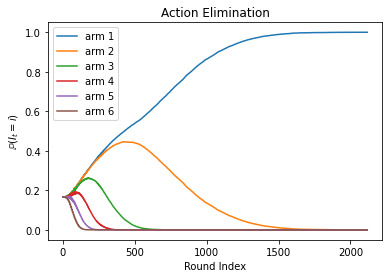

In [4]:
# plot the figure

# define auxiliary function to calculate the proportion of indices
def rolling_mean(arr, n=6):
    ret = np.cumsum(arr)
    ret[n:] = ret[n:]-ret[:-n]
    return ret[n-1:] / n
    # example: 
    # rolling_mean(arr=np.arange(1, 10), n=4) will return
    # array([2.5, 3.5, 4.5, 5.5, 6.5, 7.5])

# split the record of each arm
AE_arm_bool = list() # each element in this list is a boolean 2d array, correpsonds to each arm
for kk in range(1, K+1):
    temp_list = list()
    for exp_index in range(n_experiment):
        temp_list.append(action_history_AE[exp_index]==kk)
    AE_arm_bool.append(temp_list)

# calculate the proportion of indices
AE_arm_average = list()
for kk in range(K):
    temp_list = list()
    for exp_index in range(n_experiment):
        temp_list.append(rolling_mean(arr=AE_arm_bool[kk][exp_index], n=K))
    AE_arm_average.append(temp_list)
    
# get the length of longest experiment
count_max = 0
for exp_index in range(n_experiment):
    if count_max < len(AE_arm_average[0][exp_index]):
        count_max = len(AE_arm_average[0][exp_index])
print(f"length of longest experiment {count_max}")

# plot the figure
plt.figure()
for kk in range(K):
    AE_arm_average_np = np.zeros((n_experiment, count_max))
    for exp_index in range(n_experiment):
        length = len(AE_arm_average[kk][exp_index])
        AE_arm_average_np[exp_index, 0:length] = AE_arm_average[kk][exp_index]
        AE_arm_average_np[exp_index, length:] = (prediction_AE[exp_index]==kk+1).astype(np.float64)
    AE_arm_average_np = np.mean(AE_arm_average_np, axis=0)
    plt.plot(np.arange(1, count_max+1), AE_arm_average_np, label=f"arm {kk+1}")
    
plt.xlabel("Round Index")
plt.ylabel(r"$\mathbb{P}(I_t=i)$")
plt.title("Action Elimination")
plt.legend()
plt.show()